In [ ]:
pip install numpy opencv-python matplotlib

In [ ]:
import cv2
import numpy as np
import os # Ajout pour gérer les chemins de fichiers

def image_load(image_path, color_mode='rgb'):
    """
    Charge une image depuis un chemin de fichier.

    :param image_path: Chemin vers le fichier image.
    :param color_mode: 'rgb' ou 'gray' pour charger en couleur ou en niveaux de gris.
    :return: L'image chargée comme un tableau NumPy.
    """
    assert os.path.exists(image_path), f"Erreur: Le fichier '{image_path}' n'a pas été trouvé."

    if color_mode == 'gray':
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # TODO2: Assertion pour tester s'il s'agit d'une image en niveaux de gris
        assert len(image.shape) == 2, "Erreur: L'image chargée n'est pas en niveaux de gris."
    else: # Par défaut, charge en RGB
        image = cv2.imread(image_path)
        # OpenCV charge en BGR, on convertit en RGB pour la cohérence
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # TODO2: Assertion pour tester s'il s'agit d'une image RGB
        assert len(image.shape) == 3 and image.shape[2] == 3, "Erreur: L'image chargée n'est pas RGB."

    assert image is not None, f"Impossible de charger l'image depuis '{image_path}'"
    print(f"Image '{image_path}' chargée avec succès (mode: {color_mode}).")
    return image

In [ ]:
def convolve_channel(image, kernel):
    """Applique une convolution sur un seul canal d'image."""
    # Assertions pour valider les dimensions
    assert image.ndim == 2, "La fonction convolve_channel ne traite que les images 2D (canaux uniques)."
    assert image.shape[0] >= kernel.shape[0], "L'image est trop petite pour le noyau en hauteur."
    assert image.shape[1] >= kernel.shape[1], "L'image est trop petite pour le noyau en largeur."

    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Ajout d'un padding (rembourrage) avec des zéros sur les bords
    # La citation  a été retirée de cette ligne
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    output = np.zeros_like(image, dtype=np.float32)

    # Application de la convolution
    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = np.sum(region * kernel)

    assert output.shape == image.shape, "La taille de l'image de sortie doit être la même que l'image d'entrée."

    return output

In [ ]:
import matplotlib.pyplot as plt

def display_results(image_list, title_list):
    """
    Affiche une liste d'images avec leurs titres dans une seule figure.

    :param image_list: Liste des images (tableaux NumPy).
    :param title_list: Liste des titres correspondants.
    """
    assert len(image_list) == len(title_list), "Le nombre d'images et de titres doit être le même."

    plt.figure(figsize=(15, 8))
    num_images = len(image_list)

    for i, (image, title) in enumerate(zip(image_list, title_list)):
        plt.subplot(1, num_images, i + 1)
        plt.title(title)
        # Déterminer la cmap pour matplotlib
        cmap = 'gray' if image.ndim == 2 else None
        plt.imshow(image, cmap=cmap)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def apply_convolution(image, kernel):
    """Applique un noyau de convolution sur une image (niveaux de gris ou RGB)."""
    # Assertions pour valider les entrées
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy."
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy."
    assert kernel.ndim == 2, "Le noyau doit être une matrice 2D."
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1, "Le noyau doit avoir des dimensions impaires."

    if image.ndim == 3:  # Image RGB
        assert image.shape[2] == 3, "L'image RGB doit avoir 3 canaux."
        # Appliquer le filtre sur chaque canal séparément
        output = np.zeros_like(image, dtype=np.float32)
        for c in range(image.shape[2]):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel)
    else:  # Image en niveaux de gris
        output = convolve_channel(image, kernel)

    # TODO: Ajouter les assertions pour la taille de la sortie
    assert output.shape == image.shape, "La taille de l'image de sortie doit correspondre à celle de l'entrée."

    # Normaliser pour ramener les valeurs dans l'intervalle [0, 255]
    output = np.clip(output, 0, 255).astype(np.uint8)

    return output

In [ ]:
# 1. Filtre de flou (moyenne) 3x3
blur_kernel_3x3 = np.ones((3, 3), np.float32) / 9

# Filtre de flou 7x7 (pour comparer les effets de taille)
blur_kernel_7x7 = np.ones((7, 7), np.float32) / 49

# 2. Filtre Sobel horizontal
sobel_horizontal = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

# 3. Filtre Sobel vertical
sobel_vertical = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float32)

# 4. Filtre de netteté (Sharpen) - exemple tiré de la page Wikipedia
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=np.float32)

# 5. Détection de tous les contours (Laplacien)
laplacian_kernel = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
], dtype=np.float32)

# TODO: Ajouter des filtres aléatoires avec une seed
np.random.seed(42) # Pour des résultats reproductibles
random_kernel_5x5 = np.random.randn(5, 5)

# Normalisons le filtre aléatoire pour que sa somme soit 1 (comme un flou) ou 0 (comme un détecteur de contours)
# Ici, nous le normalisons pour qu'il ne surexpose pas l'image.
random_kernel_5x5 /= np.sum(np.abs(random_kernel_5x5))

# Dictionnaire pour organiser tous les filtres
kernels = {
    "Flou 3x3": blur_kernel_3x3,
    "Flou 7x7": blur_kernel_7x7,
    "Sobel Horizontal": sobel_horizontal,
    "Sobel Vertical": sobel_vertical,
    "Netteté": sharpen_kernel,
    "Laplacien": laplacian_kernel,
    "Aléatoire 5x5": random_kernel_5x5
}

Image 'cablecar.ppm' chargée avec succès (mode: gray).
Image 'cablecar.ppm' chargée avec succès (mode: rgb).

Application des filtres sur l'image en niveaux de gris...
 - Application du filtre : Flou 3x3
 - Application du filtre : Flou 7x7
 - Application du filtre : Sobel Horizontal
 - Application du filtre : Sobel Vertical
 - Application du filtre : Netteté
 - Application du filtre : Laplacien
 - Application du filtre : Aléatoire 5x5


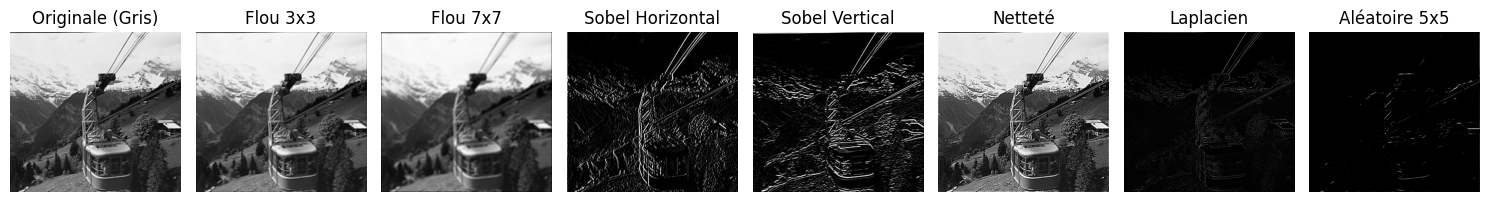


Application des filtres sur l'image RGB...
 - Application du filtre : Flou 3x3
 - Application du filtre : Flou 7x7
 - Application du filtre : Sobel Horizontal
 - Application du filtre : Sobel Vertical
 - Application du filtre : Netteté
 - Application du filtre : Laplacien
 - Application du filtre : Aléatoire 5x5


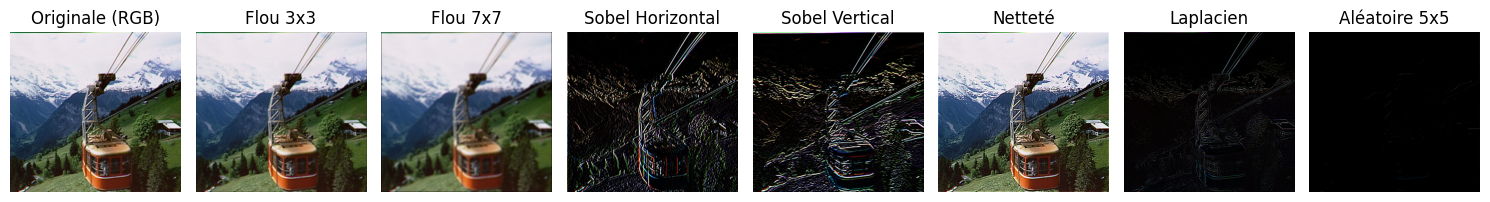

In [ ]:
def main():
    # --- Chargement de l'image ---
    image_path = 'cablecar.ppm' # Assurez-vous d'avoir cette image ou une autre

    # Travailler sur les deux types d'images
    gray_image = image_load(image_path, color_mode='gray')
    rgb_image = image_load(image_path, color_mode='rgb')

    # --- Traitement de l'image en niveaux de gris ---
    gray_filtered_images = [gray_image]
    gray_titles = ["Originale (Gris)"]

    print("\nApplication des filtres sur l'image en niveaux de gris...")
    for name, kernel in kernels.items():
        print(f" - Application du filtre : {name}")
        filtered_img = apply_convolution(gray_image, kernel)
        gray_filtered_images.append(filtered_img)
        gray_titles.append(name)

        # Sauvegarder le résultat
        output_filename = f"lena_gray_{name.lower().replace(' ', '_')}.png"
        cv2.imwrite(output_filename, filtered_img)

    # Afficher tous les résultats pour l'image grise
    display_results(gray_filtered_images, gray_titles)

    # --- Traitement de l'image RGB ---
    rgb_filtered_images = [rgb_image]
    rgb_titles = ["Originale (RGB)"]

    print("\nApplication des filtres sur l'image RGB...")
    for name, kernel in kernels.items():
        print(f" - Application du filtre : {name}")
        filtered_img = apply_convolution(rgb_image, kernel)
        rgb_filtered_images.append(filtered_img)
        rgb_titles.append(name)

        # Sauvegarder le résultat (en convertissant de RGB à BGR pour OpenCV)
        output_filename = f"lena_rgb_{name.lower().replace(' ', '_')}.png"
        cv2.imwrite(output_filename, cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR))

    # Afficher tous les résultats pour l'image RGB
    display_results(rgb_filtered_images, rgb_titles)

if __name__ == '__main__':
    main()